In [46]:
from tensorboard.backend.event_processing import event_accumulator
import os
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
file = '20_09_20/3c_bloodgroup_5m_method2_withreset_1/' +'events.out.tfevents.1600588021.Ronalds-MBP.localdomain'
# files are large (200+ Mb, might take a while)
ea = event_accumulator.EventAccumulator(file,
                                        size_guidance={ # might be removed?
                                            event_accumulator.COMPRESSED_HISTOGRAMS: 500,
                                            event_accumulator.IMAGES: 4,
                                            event_accumulator.AUDIO: 4,
                                            event_accumulator.SCALARS: 0,
                                            event_accumulator.HISTOGRAMS: 1,})
ea.Reload() # loads events from file
ea.Tags()

In [ ]:
def find(name, path):
    for root, dirs, files in os.walk(path):
        if name in files:
            return os.path.join(root, name)

In [153]:
def merge_results(file_name):
    
    # Import the correct files
    # Tensorboard (tb) event file
    tb_path = 'results/tensorboard_data/'
    tb_file_name = file_name+'_1'
    for root, dirs, files in os.walk(tb_path):
        if tb_file_name in dirs:
            tb_file_path =  os.path.join(root, tb_file_name)
    tb_file = os.listdir(tb_file_path)[0]
    tb_event_file = tb_file_path+'/'+tb_file
 
    # Metrics (mt) csv files
    mt_path = 'results/evaluation_metrics_data/'
    mt_file_name = file_name+'.csv'
    mt_file = mt_path + mt_file_name
    
    # Load the TB data
    # files are large (200+ Mb, might take a while)
    print('start import from tensorboard event')
    ea = event_accumulator.EventAccumulator(tb_event_file)
    ea.Reload() # loads events from file
    ea.Tags()
    print('import from tensorboard event done')
    # Convert to pandas
    tb_df = pd.DataFrame(ea.Scalars('episode_reward'))
    
    # Load the MT data & convert to pandas
    mt_column_list = ["match", "infeasible_match", "mismatch", "notinstock", "total_removed"]
    mt_df = pd.read_csv(mt_file, names=mt_column_list)    
    
    # Combine the data
    df_combined = pd.concat([tb_df, mt_df], axis=1, sort=False)
    
    # Save the data
    df_combined_file_name = 'results/combined_data/' + file_name + '.csv'
    df_combined.to_csv(df_combined_file_name ,index=False)
    return df_combined

test_result = merge_results('2020_09_21_08_01_3c_bloodgroup_5m_method1_withreset')

start import from tensorboard event


Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.


import from tensorboard event done


In [2]:
merge_results('2020_09_20_18_15_3c_bloodgroup_5m_method1_withoutreset')

NameError: name 'merge_results' is not defined

In [62]:
test_result.columns

Index(['wall_time', 'step', 'value', 'match', 'infeasible_match', 'mismatch',
       'notinstock', 'total_removed'],
      dtype='object')

In [64]:
data_list = [test_result['infeasible_match'], test_result['mismatch'], test_result['notinstock'], test_result['total_removed']]
test_labelas = ['inf', 'mis', 'notstock', 'tot_rem']

# GRAPH CREATION

In [77]:
def smooth(scalars, weight):  # Weight between 0 and 1
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value

    return smoothed

In [78]:
smooth([1,2,3], 0.99)

[1.0, 1.01, 1.0299]

In [179]:
def plot_compare_creation(data_list, labels, smoothing = 0.5, ylim_cutoff = 0):
    """
    data_list is a list of data in a list: [[1,2,3,4]]
    labels: ['label1', "label2"]
    """
    ylim_list = []
    plt.figure(num=None, figsize=(20, 6), dpi=300, facecolor='w', edgecolor='k')
    color_list = ['blue', 'red', 'green', 'orange', 'black']
    for idx, data in enumerate(data_list):
        x  = list(range(len(data)))
        data_smooth = smooth(data, smoothing)
        plt.plot(x, data_smooth, label=labels[idx], color = color_list[idx])
        plt.plot(x, data, color = color_list[idx], alpha=0.1)
        cutoff = round(len(data)*(1-ylim_cutoff))-1
        ylim_list.append(sorted(data)[cutoff])


        
   
    plt.legend()
    ylim_value = max(ylim_list)


    plt.ylim(0,ylim_value)
    plt.xlabel("Episodes")
    plt.show()
    


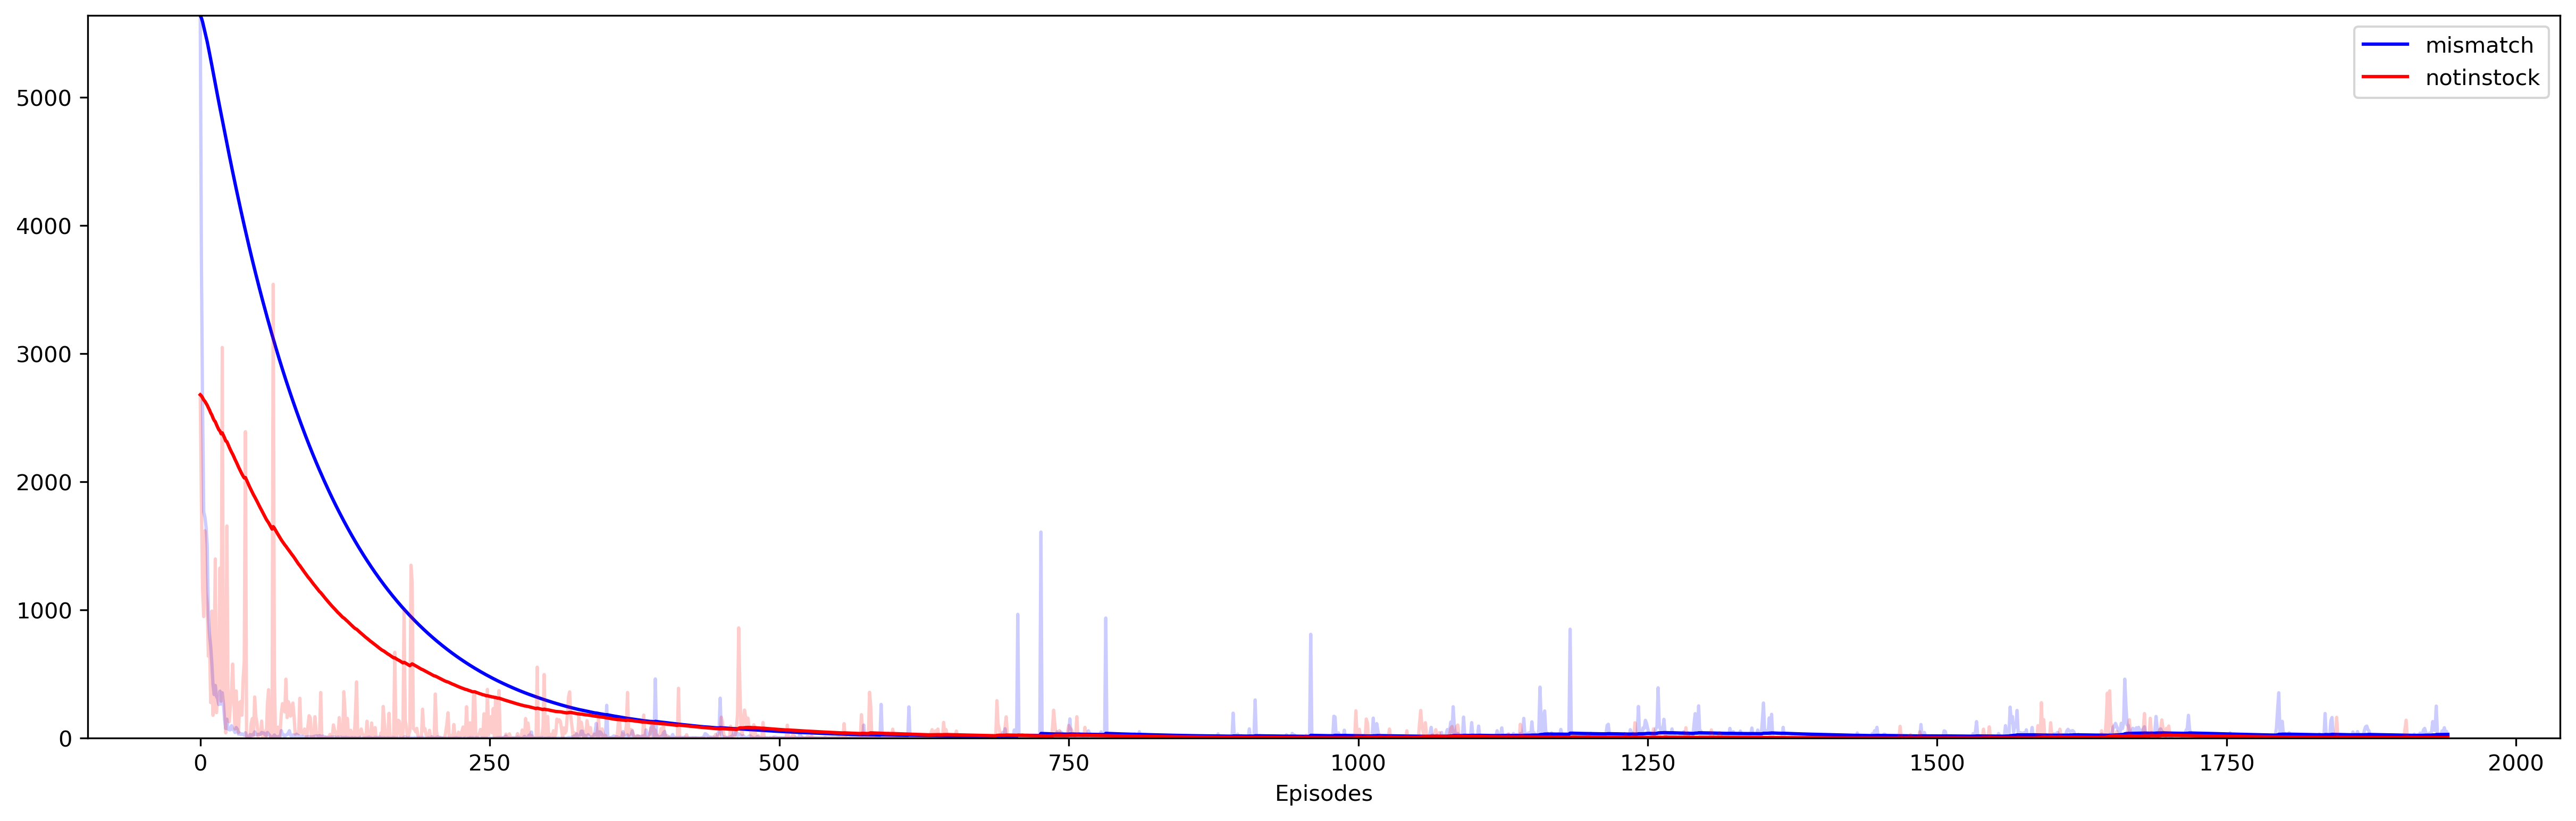

In [144]:
plot_compare_creation([test_result['mismatch'], test_result['notinstock']], ['mismatch', 'notinstock'], 0.99)

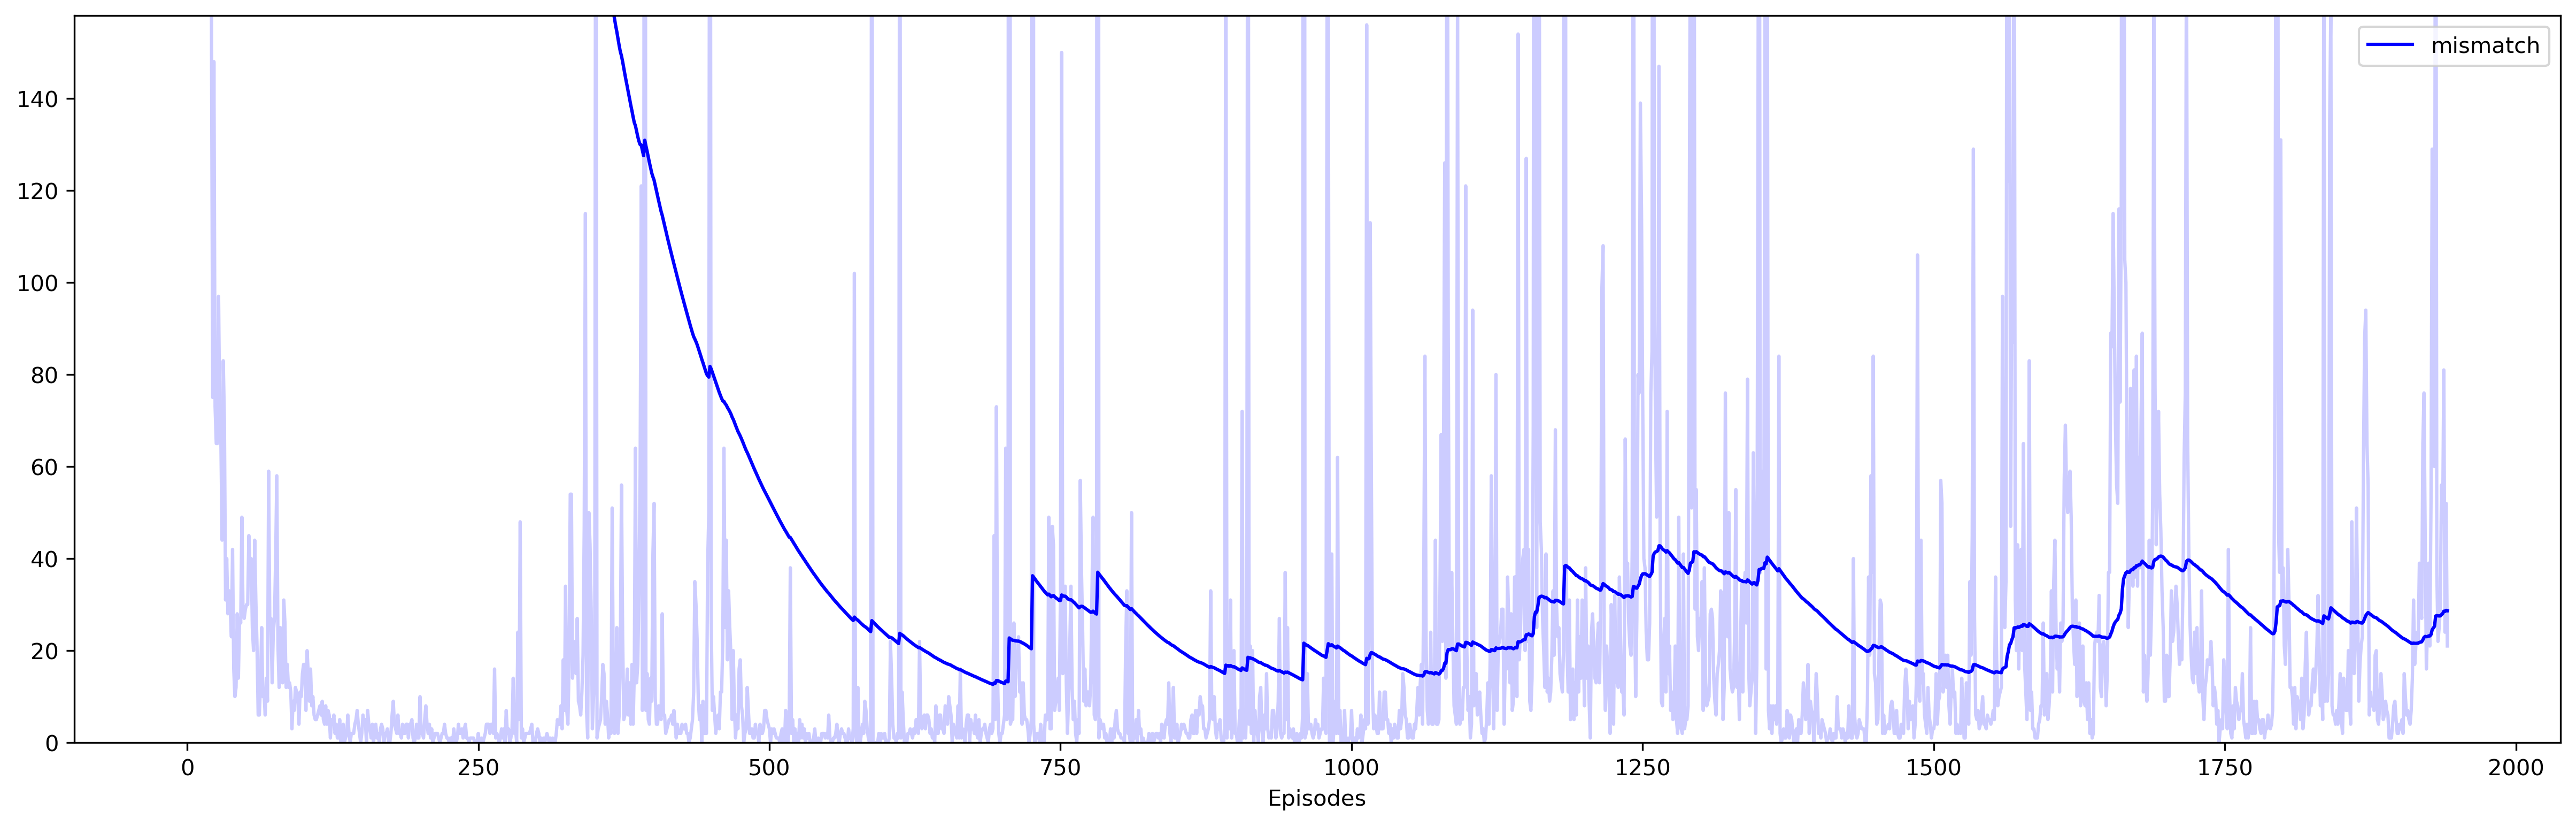

In [151]:
plot_compare_creation([test_result['mismatch']], ['mismatch'], smoothing = .99, ylim_cutoff=0.03)

In [115]:
cutoff = round(len(list(test_result['mismatch']))*0.99)
sorted(list(test_result['mismatch']))[cutoff]


805

In [156]:
method2_withoutreset = pd.read_csv('results/combined_data/2020_09_20_09_47_3c_bloodgroup_5m_method2_withoutreset.csv') 
method2_withreset = pd.read_csv('results/combined_data/2020_09_20_13_55_3c_bloodgroup_5m_method2_withreset.csv')
method1_withreset = pd.read_csv('results/combined_data/2020_09_20_18_15_3c_bloodgroup_5m_method1_withreset.csv')
method1_withoutreset = pd.read_csv('results/combined_data/2020_09_21_08_01_3c_bloodgroup_5m_method1_withoutreset.csv')

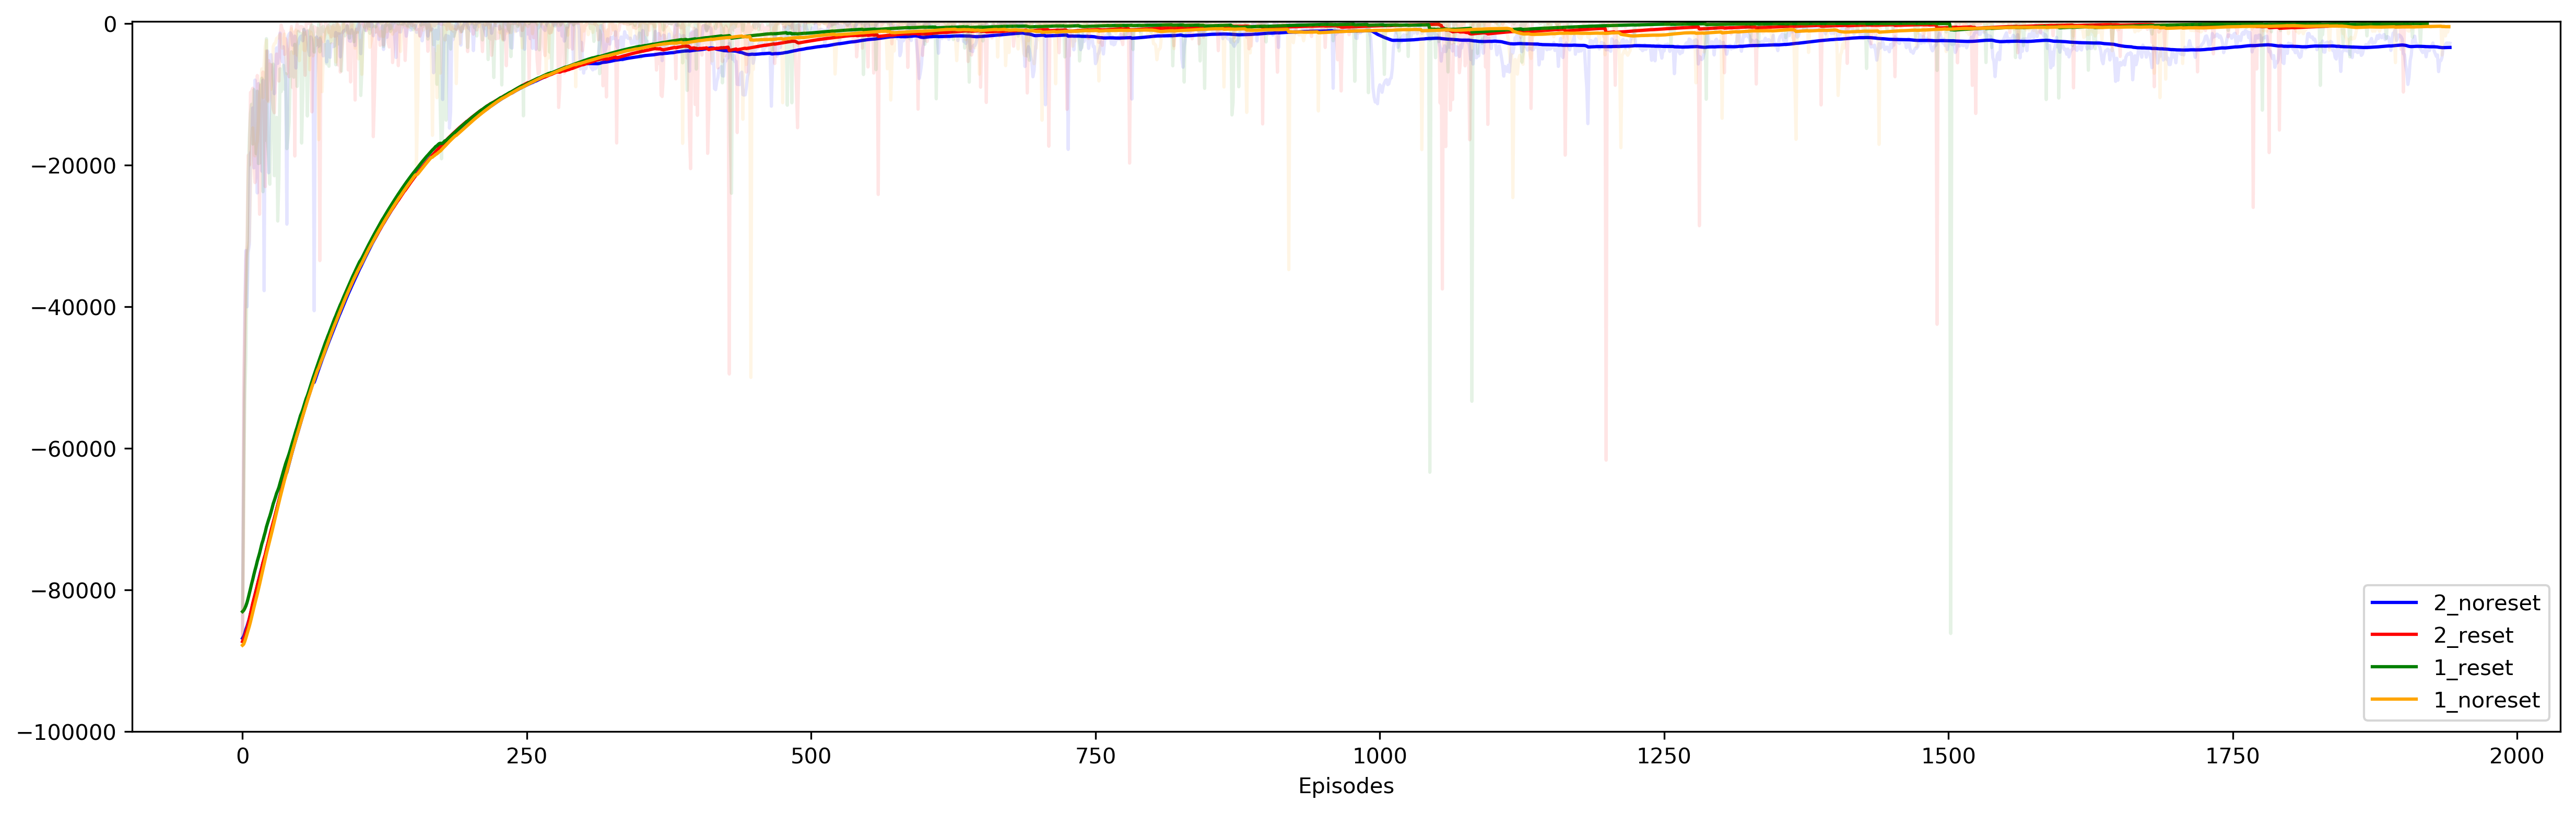

In [170]:
data_value = [list(method2_withoutreset['value']), list(method2_withreset['value']), list(method1_withreset['value']), list(method1_withoutreset['value'])]
labels_value = ['2_noreset', '2_reset', '1_reset', '1_noreset']
plot_compare_creation(data_value, labels_value, smoothing = .99, ylim_cutoff=0)

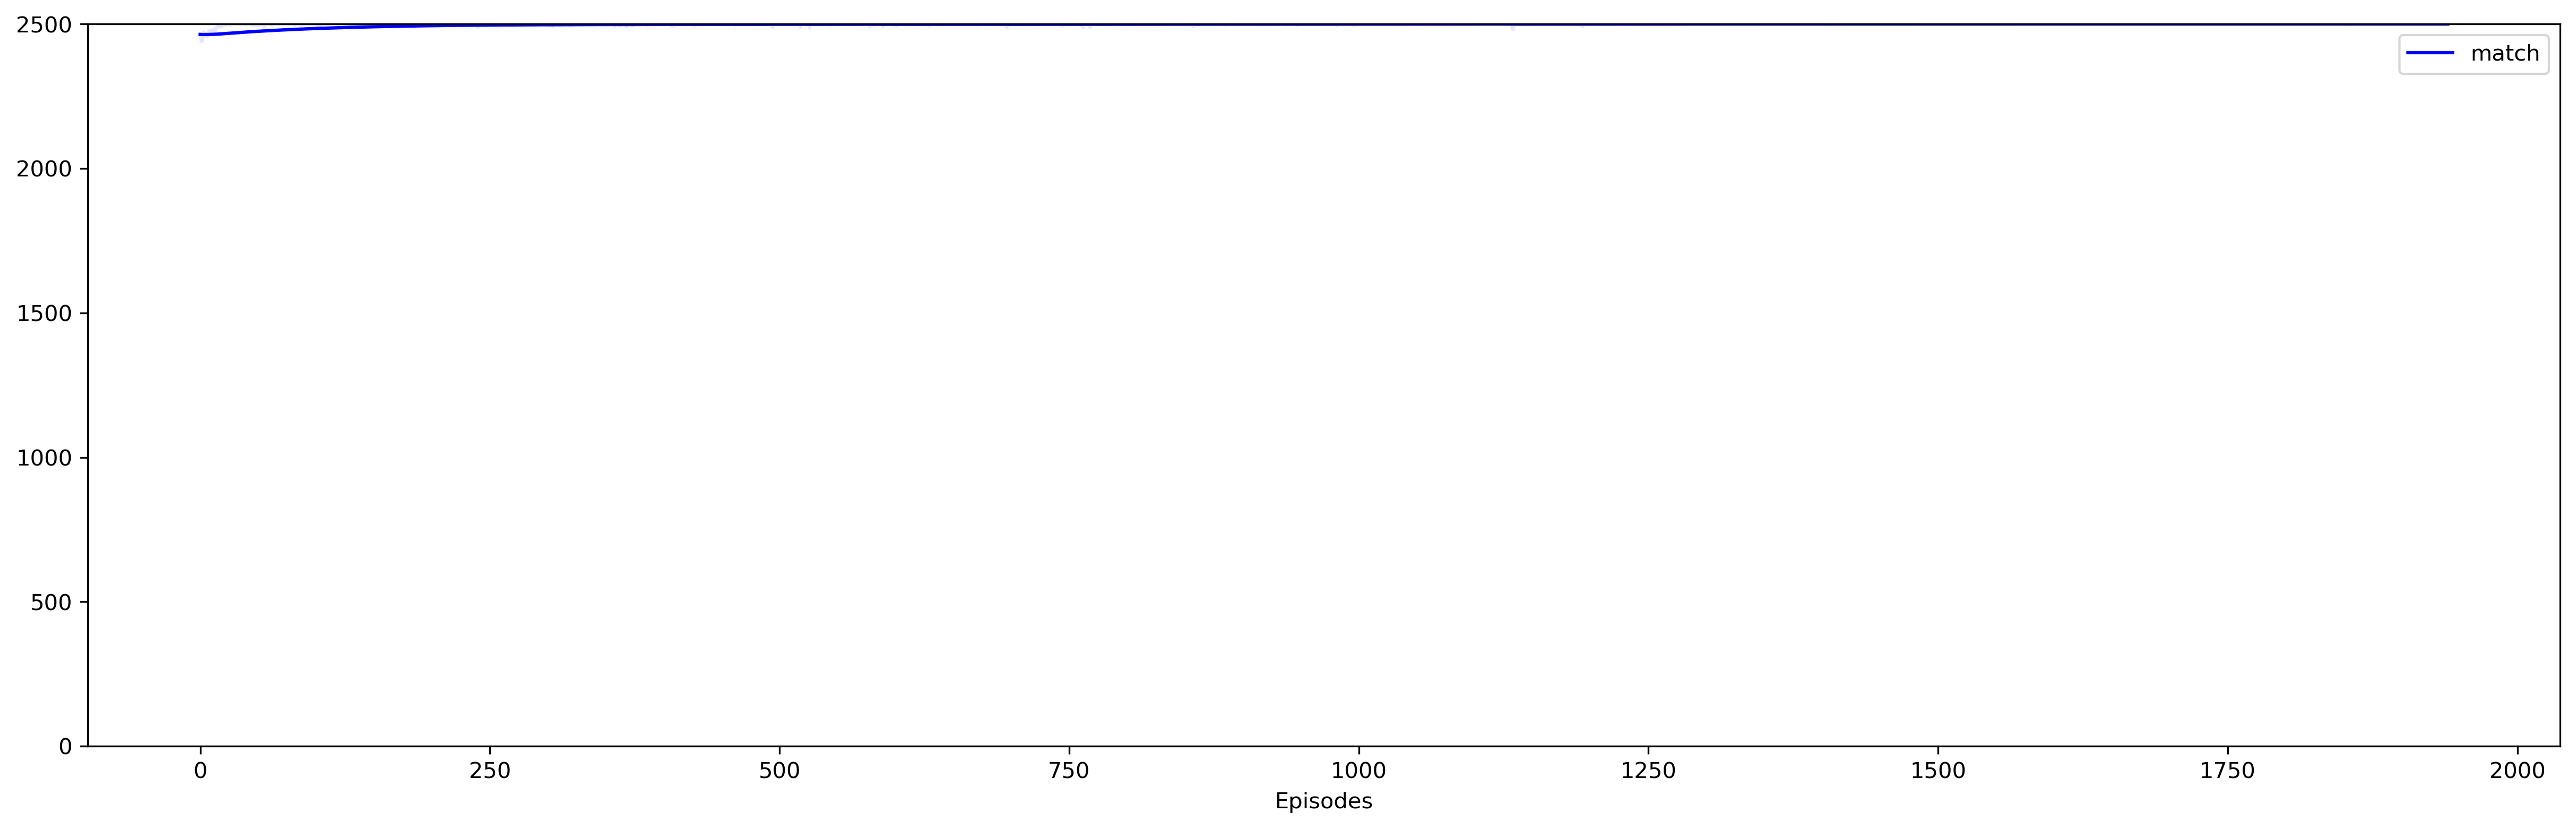

In [184]:
plot_compare_creation([method1_withoutreset['match']], ['match'], smoothing = .99, ylim_cutoff=0)

In [ ]:
'match', 'infeasible_match', 'mismatch',
       'notinstock', 'total_removed'

In [220]:
def plot_learning_eval(data_list, labels, smoothing=0.5, ylim_cutoff=0):
    """

    :param data_list: nested list, data to be shown. [[data1.1, data1.2],[data2]]
    :param labels: list of strings, ['name of data1', 'name of data2']
    :param smoothing: float, number to provide smoothing
    :param ylim_cutoff: cutoff value in limiting.
    :return:
    """
    ylim_list_max = []
    ylim_list_min = []
    plt.figure(num=None, figsize=(20, 6), dpi=300, facecolor='w', edgecolor='k')
    color_list = ['blue', 'red', 'green', 'orange', 'black']
    for idx, data in enumerate(data_list):
        x = list(range(len(data)))
        data_smooth = smooth(data, smoothing)
        plt.plot(x, data_smooth, label=labels[idx], color=color_list[idx])
        plt.plot(x, data, color=color_list[idx], alpha=0.2)


        cutoff_max = round(len(data) * (1 - ylim_cutoff)) - 1
        ylim_list_max.append(sorted(data)[cutoff_max])
        cutoff_min = round(len(data) * (1 - ylim_cutoff)) - 1
        ylim_list_min.append(sorted(data, reverse=True)[cutoff_min])

    plt.legend()
    ylim_value_max = max(ylim_list_max)
    ylim_value_min = min(ylim_list_min)
    min_value = ylim_value_min - ((ylim_value_max-ylim_value_min)/10)
    max_value = ylim_value_max + ((ylim_value_max-ylim_value_min)/10)
    if ylim_value_min < 0:
        plt.ylim(min_value, max_value)
    elif ylim_value_min > 20:
        min_value = ylim_value_min - ((ylim_value_max-ylim_value_min)/10)
        plt.ylim(min_value, max_value)
    else:
        plt.ylim(0, max_value)


    plt.xlabel("Episodes")
    plt.show()

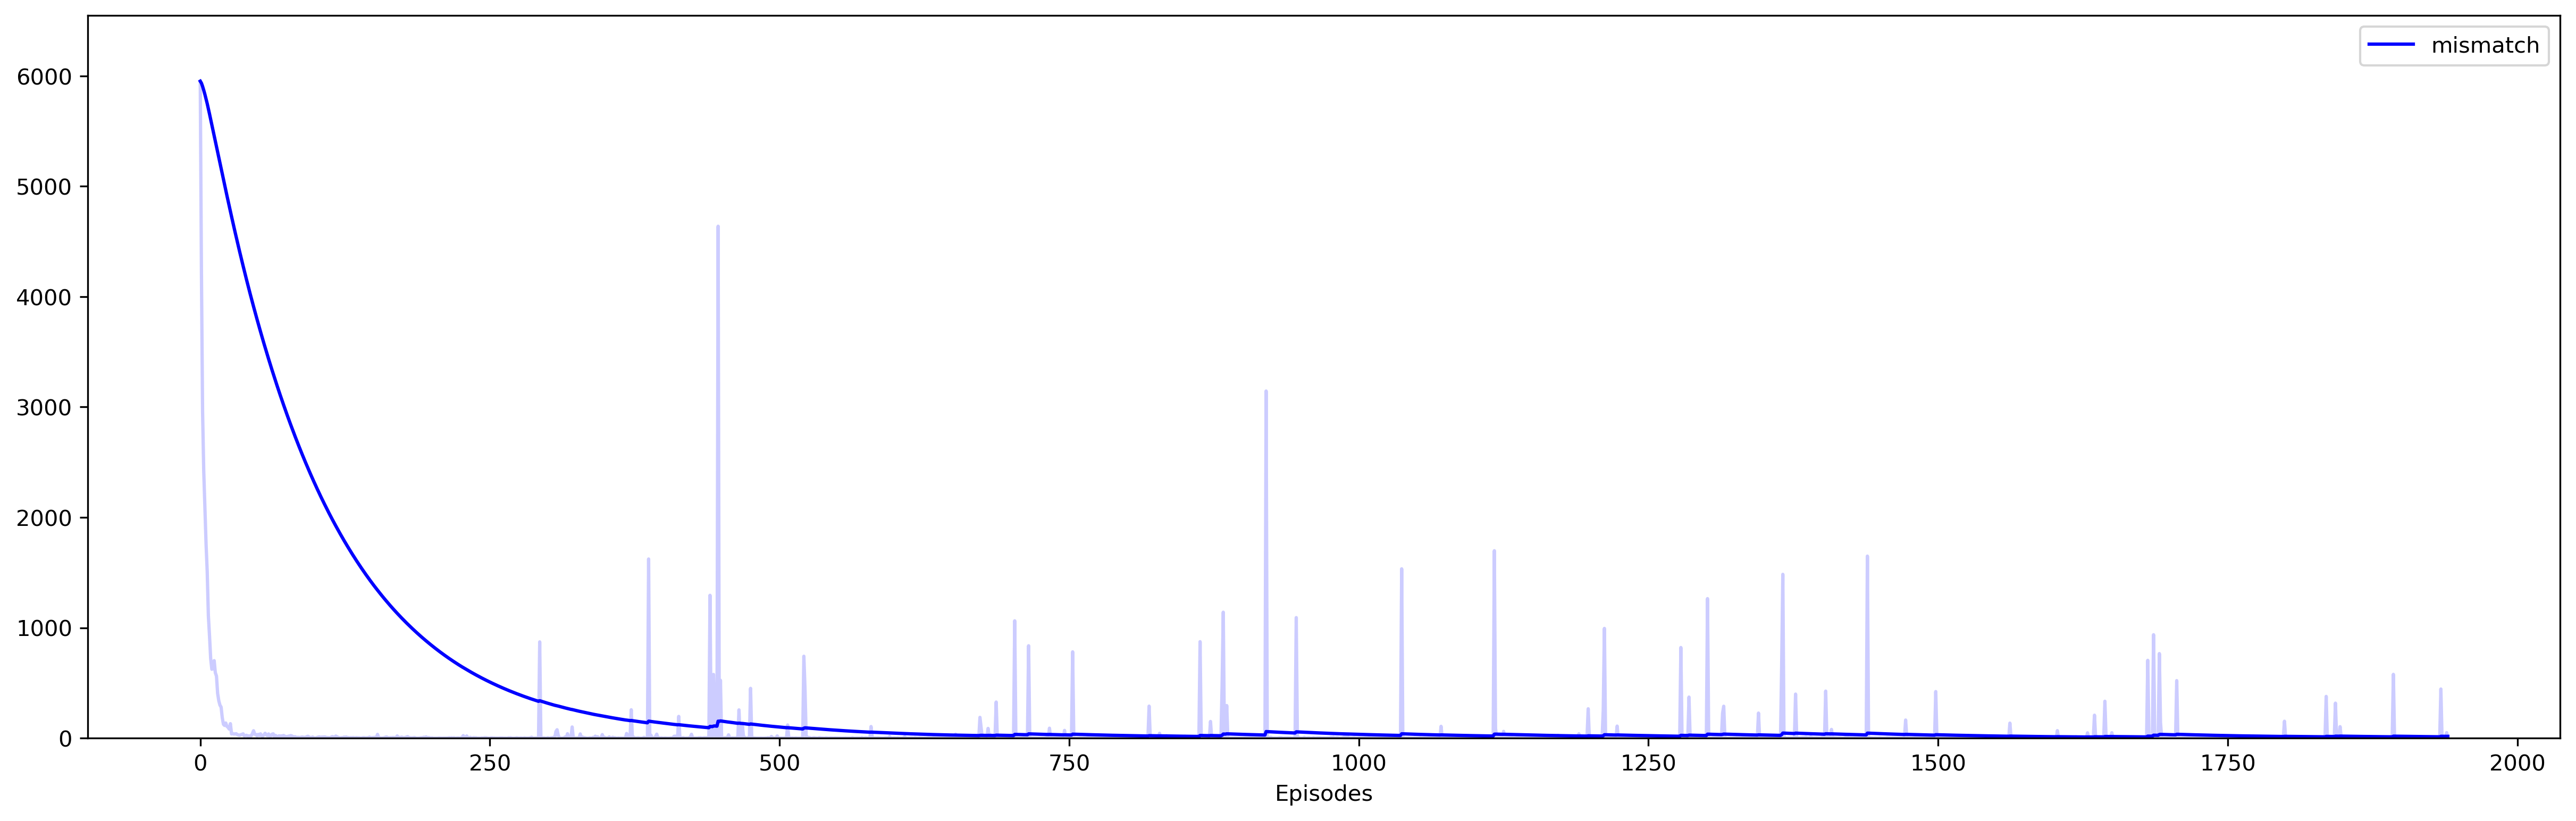

In [221]:
plot_learning_eval([method1_withoutreset['mismatch']], ['mismatch'], smoothing = 0.99, ylim_cutoff=0.00)

In [ ]:
'match', 'infeasible_match', 'mismatch',
       'notinstock', 'total_removed'